<a href="https://www.kaggle.com/code/ryanlliu/baseline-model?scriptVersionId=160985362" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Recap: EDA
- 78 Video:
  - 6224 frame images
  - 6224 mask images (pixels in image = [0, 7, 8])
  - 6224 mask enhance images (pixels in image are scaled to [0,255])
- The processed size is 1295x1026
- Frame label count: (6, 3743), (5, 1136), (3, 1022), (4, 323)
  - Label 3-None, 4-OnlySP, 5-OnlyHead, 6-SP+Head in framelabel.csv

In [1]:
import os
import random
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

# for read img
from PIL import Image
import cv2

from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


To ensure the reproducibility, we will control the seed of random generators

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Prepare dataset

In [3]:
dataset_path = '/kaggle/input/jnu-ifm-for-segment-pubic-symphysis-fetal-head/dataset'
print(os.listdir(dataset_path))

mask_dir = 'mask'
img_paths = os.listdir(f'{dataset_path}/image')
mask_paths = os.listdir(f'{dataset_path}/{mask_dir}')

print(f'{len(img_paths)} frame images')
print(f'{len(mask_paths)} {mask_dir} images')

['enhance_mask', 'frame_label.csv', 'mask', 'image']
6224 frame images
6224 mask images


In [4]:
# Mapping 1-1 between mask and image
imgs = [img.replace("_mask", "") for img in mask_paths]

# Define dataset
- load images and masks, apply transformations, and return them as a dictionary

In [5]:
print(len(imgs))
print(len(mask_paths))

6224
6224


In [6]:
from sklearn.model_selection import train_test_split

train_img, test_img, train_mask, test_mask = train_test_split(imgs, mask_paths, test_size = 0.1, random_state=123)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1, random_state=123)

In [7]:
print(len(train_img))
print(len(val_img))
print(len(test_img))

5040
561
623


Double check image and mask information

Shape = (1026, 1295), uniques value = [0 7 8]


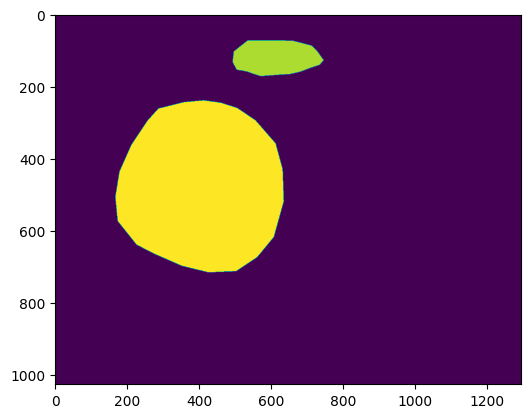

In [8]:
path = f'{dataset_path}/{mask_dir}/{train_mask[1]}'
mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
print(f'Shape = {mask.shape}, uniques value = {np.unique(mask.flatten())}')
plt.imshow(mask)
plt.show()

Shape = (1026, 1295, 3), uniques value = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72
  73  74  75  76  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 170 171 172 173 174 175 176 178 179 180 181 182 183 185 186
 187 188 189 190 192 193 194 195 196 197 199 200 201 202 203 204 206 207
 208 209 210 211 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 234 235 236 237 238 239 241 242 243 244 245 246
 248 249 2

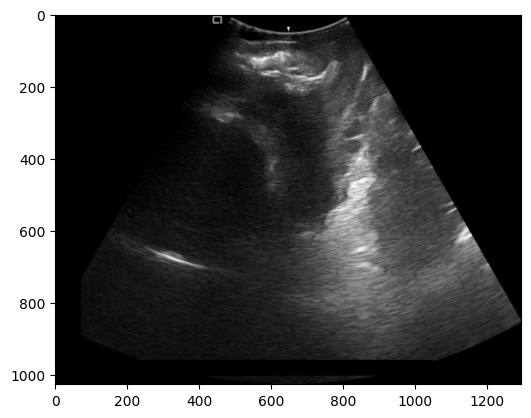

In [9]:
path = f'{dataset_path}/image/{train_img[1]}'
img = cv2.imread(path)
print(f'Shape = {img.shape}, uniques value = {np.unique(img.flatten())}')
plt.imshow(img)
plt.show()

#### Define dataset class

- For maintaining the correct proportions when resizing or displaying the content
    - we firstly center crop [1024, 1024]
    - and then resize to [128, 128]
    
    > So the content doesn’t get distorted
    > 
- For mask - need integer values for indexing or categorical representation
    - Convert mask value to class type 0, 1, 2, … (pytorch)
        - Here, 7 → 1 and 8 → 2
    - Casts the elements of the tensor to the long data type, which is PyTorch's 64-bit integer type

In [10]:
# define dataset class
class SegmentationDataset(Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = f'{dataset_path}/image/{img_name}'
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        mask_name = self.masks[idx]
        mask_path = f'{dataset_path}/{mask_dir}/{mask_name}'
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # read mask in grayscale
        
        # loss func: crossentropy just accept: 0, 1, 2, ... like indices
        mask[mask == 7] = 1 # convert mask value 7(SP) -> 1
        mask[mask == 8] = 2 # convert mask value 8(head) -> 2
        
        mask = Image.fromarray(mask)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # convert to long tensor
        # and .squeeze() > removes redundant dimensions (1, rz, rz) > (rz, rz)
        # * 255 to avoid = 0 (due to long()), since being scaling [0, 1] of ToTensor()
        mask = (mask * 255).long().squeeze() 

        return image, mask

#### Define dataset instance

In [11]:
t_test = T.Compose([
        T.CenterCrop((1024, 1024)),
        T.Resize(size=(128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.ToTensor(),
])

t_train = T.Compose([
        T.CenterCrop((1024, 1024)),
        T.Resize(size=(128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=20),
        T.ToTensor(),
        T.RandomErasing(p=0.2),
])

train_set = SegmentationDataset(train_img, train_mask, transform=t_train)
val_set = SegmentationDataset(val_img, val_mask, transform=t_test)
test_set = SegmentationDataset(test_img, test_mask, transform=t_test)

img, mask = train_set[0]
print(f'{mask.shape}, {torch.unique(mask)}')

torch.Size([128, 128]), tensor([0, 2])


#### Instantiate dataloaders

In [12]:
b_sz = 8

train_loader = DataLoader(dataset=train_set, batch_size=b_sz, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset=val_set, batch_size=b_sz, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_set, batch_size=b_sz, shuffle=True, num_workers=2)

#### Test dataloaders

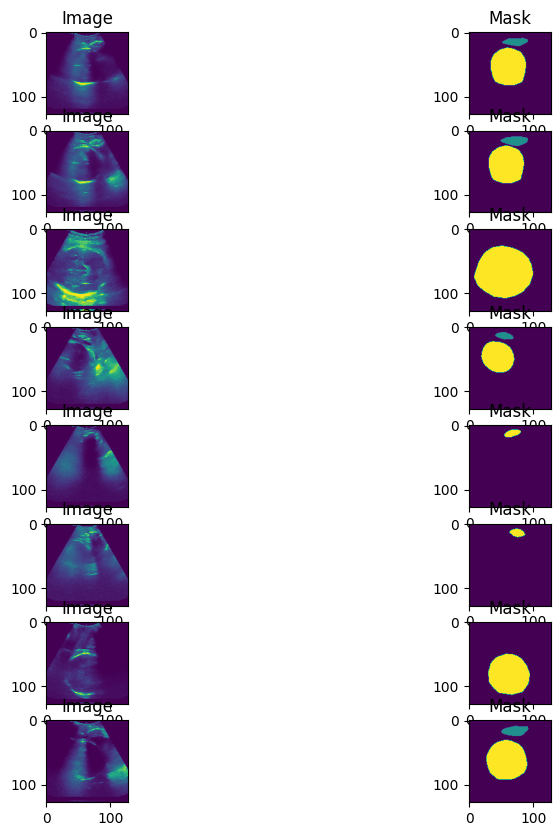

In [13]:
def visualize(loader, n=b_sz):
    # Get a batch of images and masks from the loader
    images, masks = next(iter(loader))

    # Plot the images and masks in a grid
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 10))
    for i in range(n):
        axes[i, 0].imshow(images[i].permute(1, 2, 0)) # show the image
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(masks[i].squeeze()) # show the mask
        axes[i, 1].set_title("Mask")
    plt.show()

# Call the visualize function on the test dataloader
visualize(val_loader)

# Baseline model

In [14]:
!pip install -q segmentation-models-pytorch

In [15]:
# Import the library
import segmentation_models_pytorch as smp

# Define the model
model = smp.Unet(
    encoder_name="resnet34", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet", # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1, # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3, # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 228MB/s]


# Loss function

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon
    
    def forward(self, y_pred, y_true):
        y_pred = F.softmax(y_pred, dim=1) # Apply a sigmoid function to the prediction
        y_pred = y_pred[:, 1, :, :] # Reshape the tensor to [8, 128, 128]
        
        # Flatten the tensors
        y_true = y_true.reshape(-1)
        y_pred = y_pred.reshape(-1)
        
        # Compute the intersection and the union
        intersection = torch.sum(y_true * y_pred)
        union = torch.sum(y_true) + torch.sum(y_pred)
        
        # Compute the Dice coefficient and return the loss
        dice = (2 * intersection + self.epsilon) / (union + self.epsilon)
        return -torch.log(dice)
    

class CombinedLoss(nn.Module):
    def __init__(self, weight=None, ce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.weight = weight
        self.ce_weight = ce_weight
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=weight)
        self.dice_loss = DiceLoss()
    
    def forward(self, y_pred, y_true):
        # Compute the cross entropy loss
        ce_loss = self.cross_entropy_loss(y_pred, y_true)
        
        # Compute the dice loss
        dice_loss = self.dice_loss(y_pred, y_true)
        
        # Return the weighted sum of both losses
        return self.ce_weight * ce_loss + (1 - self.ce_weight) * dice_loss

## Metrics

In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

# smooth to avoid divide to 0
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=3):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): # loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

# Training

In [18]:
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        # training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            image_tiles, mask_tiles = data
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            # forward
            output = model(image)
            loss = criterion(output, mask)
            # evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            # backward
            loss.backward()
            optimizer.step() # update weight          
            optimizer.zero_grad() # reset gradient
            
            # step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            # validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    # evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    # loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            # calculation mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'SegmentationModel_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            # iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [19]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = CombinedLoss(ce_weight=0.6)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.511 
Epoch:1/30.. Train Loss: 0.655.. Val Loss: 0.511.. Train mIoU:0.281.. Val mIoU: 0.319.. Train Acc:0.726.. Val Acc:0.816.. Time: 1.57m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Decreasing.. 0.511 >> 0.341 
Epoch:2/30.. Train Loss: 0.406.. Val Loss: 0.341.. Train mIoU:0.301.. Val mIoU: 0.310.. Train Acc:0.805.. Val Acc:0.793.. Time: 1.14m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Decreasing.. 0.341 >> 0.307 
Epoch:3/30.. Train Loss: 0.375.. Val Loss: 0.307.. Train mIoU:0.303.. Val mIoU: 0.318.. Train Acc:0.806.. Val Acc:0.823.. Time: 1.13m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Decreasing.. 0.307 >> 0.301 
saving model...
Epoch:4/30.. Train Loss: 0.369.. Val Loss: 0.301.. Train mIoU:0.304.. Val mIoU: 0.312.. Train Acc:0.807.. Val Acc:0.812.. Time: 1.31m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/30.. Train Loss: 0.373.. Val Loss: 0.327.. Train mIoU:0.302.. Val mIoU: 0.309.. Train Acc:0.805.. Val Acc:0.810.. Time: 1.02m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Decreasing.. 0.327 >> 0.318 
Epoch:6/30.. Train Loss: 0.366.. Val Loss: 0.318.. Train mIoU:0.303.. Val mIoU: 0.311.. Train Acc:0.806.. Val Acc:0.801.. Time: 1.15m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/30.. Train Loss: 0.363.. Val Loss: 0.327.. Train mIoU:0.303.. Val mIoU: 0.308.. Train Acc:0.806.. Val Acc:0.817.. Time: 1.12m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:8/30.. Train Loss: 0.362.. Val Loss: 0.403.. Train mIoU:0.303.. Val mIoU: 0.322.. Train Acc:0.805.. Val Acc:0.808.. Time: 1.13m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Loss Decreasing.. 0.403 >> 0.305 
Epoch:9/30.. Train Loss: 0.360.. Val Loss: 0.305.. Train mIoU:0.304.. Val mIoU: 0.315.. Train Acc:0.805.. Val Acc:0.809.. Time: 0.95m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process

Loss Decreasing.. 0.305 >> 0.302 
Epoch:10/30.. Train Loss: 0.362.. Val Loss: 0.302.. Train mIoU:0.303.. Val mIoU: 0.313.. Train Acc:0.805.. Val Acc:0.809.. Time: 0.98m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():AssertionError
: can only test a child process
  File "/op

Loss Decreasing.. 0.302 >> 0.301 
Epoch:11/30.. Train Loss: 0.352.. Val Loss: 0.301.. Train mIoU:0.306.. Val mIoU: 0.317.. Train Acc:0.807.. Val Acc:0.812.. Time: 0.99m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>    
Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
self._shutdown_workers()AssertionError
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    : if w.is_alive():
can only test a child process
  File "/op

Loss Not Decrease for 4 time
Epoch:12/30.. Train Loss: 0.353.. Val Loss: 0.307.. Train mIoU:0.305.. Val mIoU: 0.316.. Train Acc:0.806.. Val Acc:0.815.. Time: 0.98m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Decreasing.. 0.307 >> 0.294 
saving model...
Epoch:13/30.. Train Loss: 0.346.. Val Loss: 0.294.. Train mIoU:0.305.. Val mIoU: 0.316.. Train Acc:0.807.. Val Acc:0.802.. Time: 1.32m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
<function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'
can only test a child process: AssertionError
  File "/opt

Loss Not Decrease for 5 time
Epoch:14/30.. Train Loss: 0.348.. Val Loss: 0.377.. Train mIoU:0.305.. Val mIoU: 0.320.. Train Acc:0.806.. Val Acc:0.807.. Time: 0.95m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'      File "/opt/conda/lib/python3.10/multiprocessing/process.

Loss Not Decrease for 6 time
Epoch:15/30.. Train Loss: 0.344.. Val Loss: 0.379.. Train mIoU:0.306.. Val mIoU: 0.325.. Train Acc:0.807.. Val Acc:0.805.. Time: 0.96m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    if w.is_alive():
self._shutdown_workers()  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():AssertionError: 
can only test a child process  File "/opt

Loss Decreasing.. 0.379 >> 0.309 
Epoch:16/30.. Train Loss: 0.339.. Val Loss: 0.309.. Train mIoU:0.306.. Val mIoU: 0.315.. Train Acc:0.807.. Val Acc:0.812.. Time: 0.95m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>
Traceback (most recent call last):
Exception ignored in:   File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x792293e0ad40>    
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    if w.is_alive():

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can

Loss Decreasing.. 0.309 >> 0.288 
Epoch:17/30.. Train Loss: 0.336.. Val Loss: 0.288.. Train mIoU:0.307.. Val mIoU: 0.315.. Train Acc:0.808.. Val Acc:0.804.. Time: 0.95m


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 19.62 m


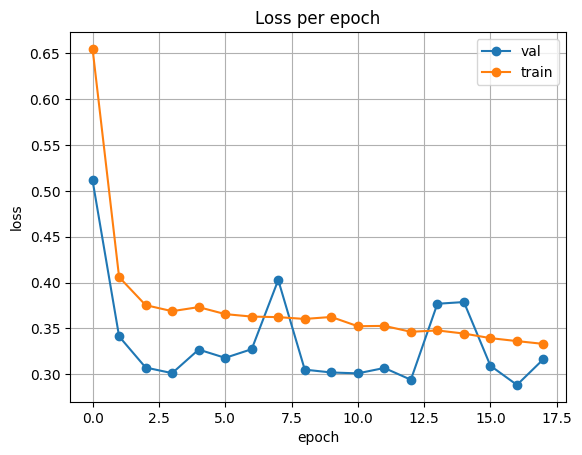

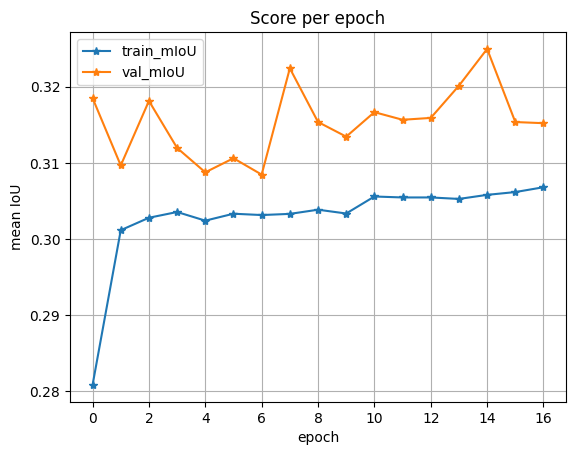

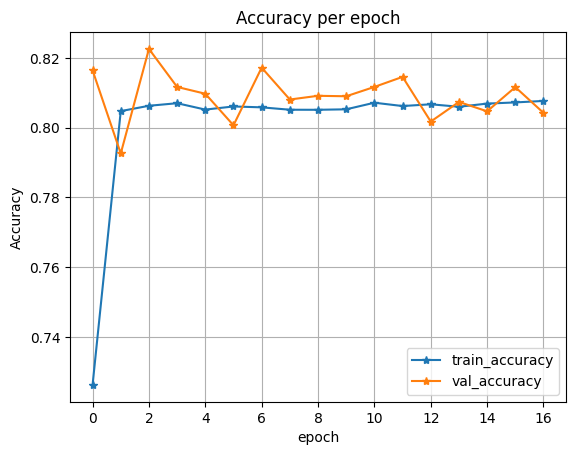

In [20]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
plot_loss(history)
plot_score(history)
plot_acc(history)

# Testing

  0%|          | 0/71 [00:00<?, ?it/s]

Test Loss: 0.2672469443999804
Test mIoU: 0.2898459447380713
Test Accuracy: 0.7474682147686298


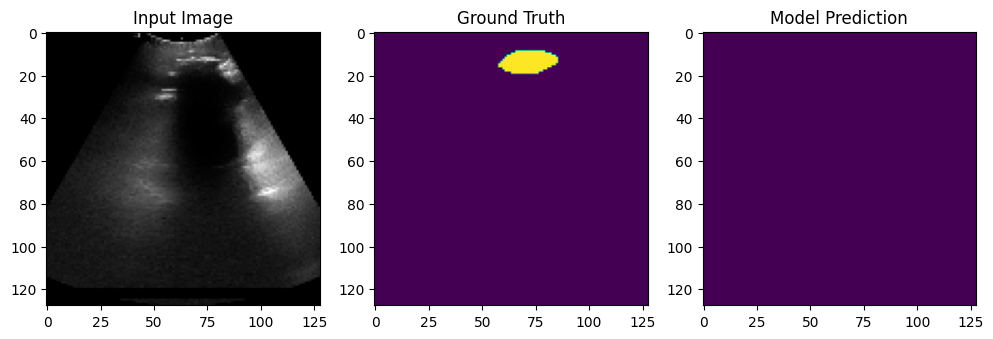

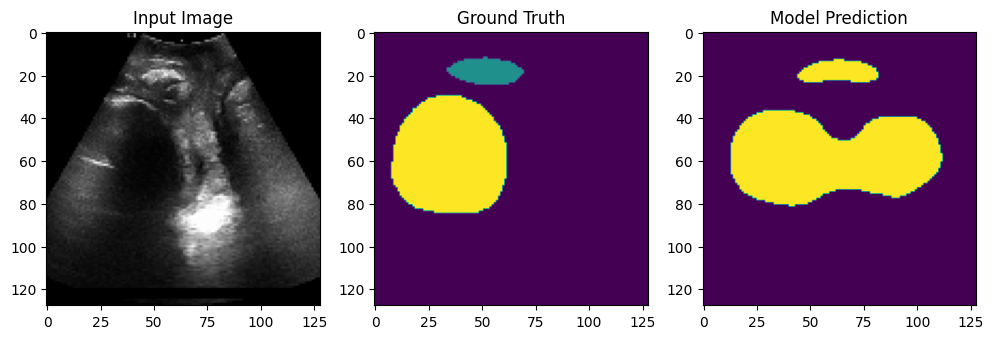

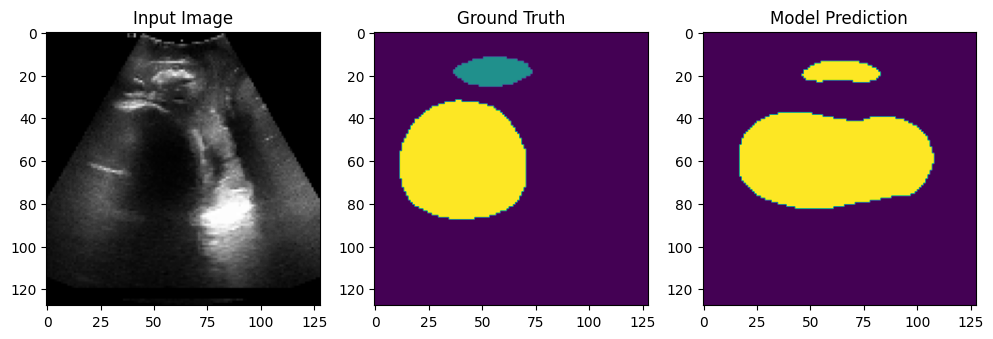

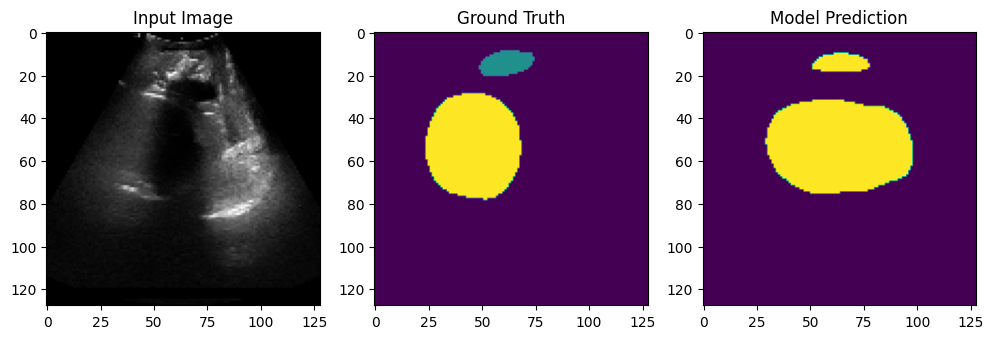

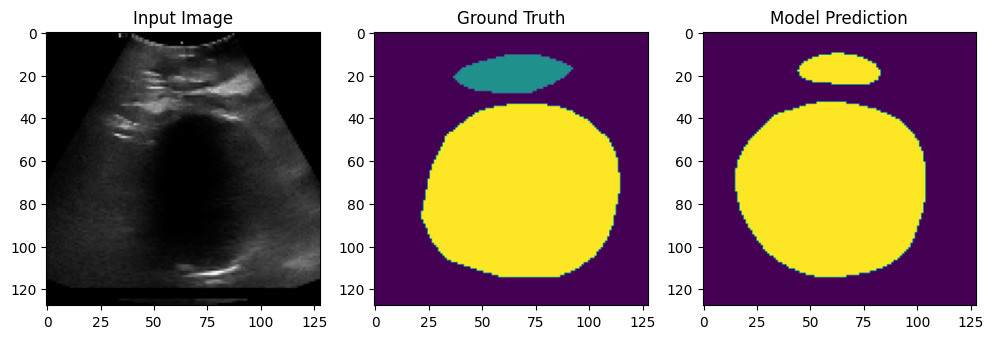

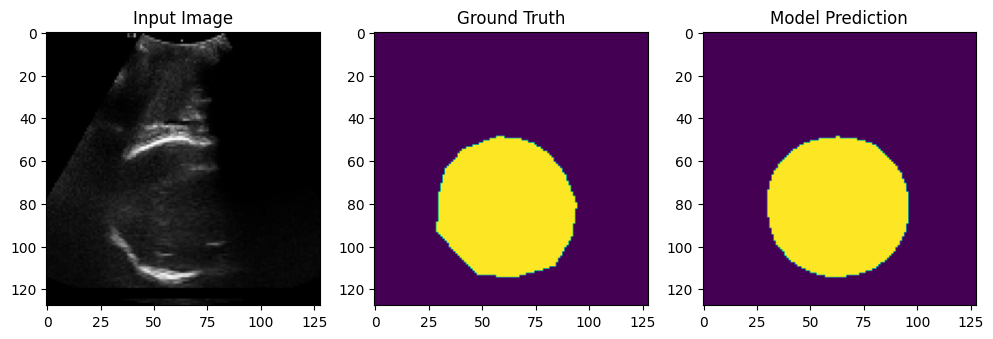

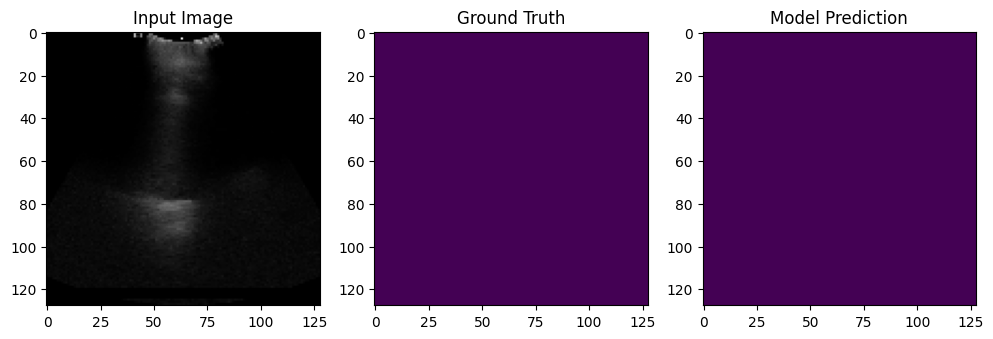

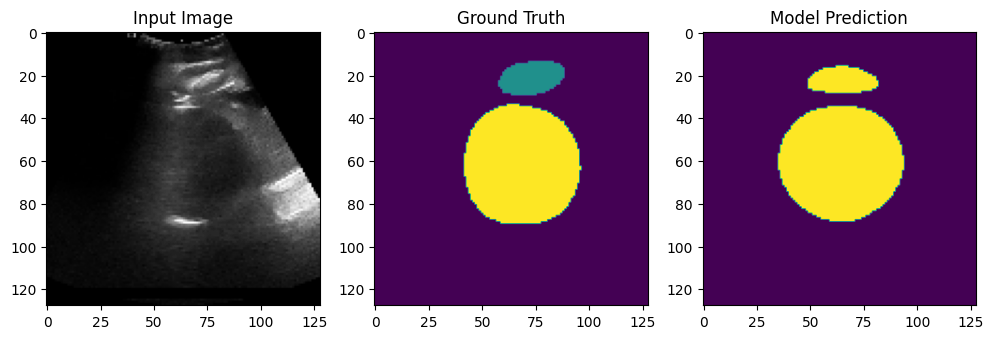

In [21]:
# Test
model.eval()
test_loss = 0.0
test_iou = 0.0
test_accuracy = 0.0

with torch.no_grad():
    for i, data in enumerate(tqdm(val_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate metrics
        test_iou += mIoU(outputs, labels)
        test_accuracy += pixel_accuracy(outputs, labels)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
average_test_iou = test_iou / len(test_loader)
average_test_accuracy = test_accuracy / len(test_loader)

print(f"Test Loss: {average_test_loss}")
print(f"Test mIoU: {average_test_iou}")
print(f"Test Accuracy: {average_test_accuracy}")

# Visualize input, ground truth, and prediction for one batch
model.eval()
with torch.no_grad():
    example_inputs, example_labels = next(iter(test_loader))
    example_inputs, example_labels = example_inputs.to(device), example_labels.to(device)
    example_outputs = model(example_inputs)

    batch_size = example_inputs.size(0)

    # Visualize input, ground truth, and prediction for the entire batch
    for i in range(batch_size):
        plt.figure(figsize=(12, 4))
        
        # Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(example_inputs[i, 0].cpu().numpy(), cmap='gray')
        plt.title('Input Image')
        
        # Ground Truth
        plt.subplot(1, 3, 2)
        plt.imshow(example_labels[i].cpu().numpy(), cmap='viridis')
        plt.title('Ground Truth')
        
        # Model Prediction
        plt.subplot(1, 3, 3)
        plt.imshow(torch.argmax(example_outputs[i], dim=0).cpu().numpy(), cmap='viridis')
        plt.title('Model Prediction')
        
        plt.show()